In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

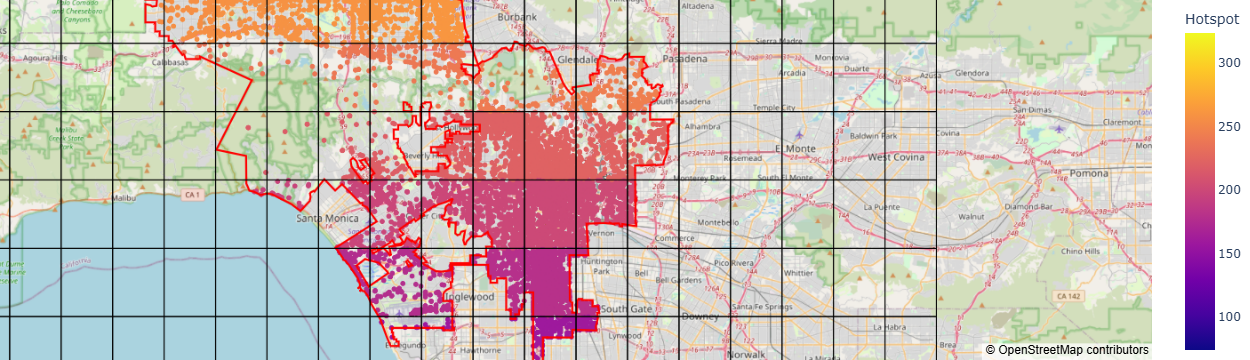

In [26]:
# grid_spatial_clustering.py

import pandas as pd
import numpy as np
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Define grid bin edges
min_lat, max_lat = 33.5, 34.6
min_lon, max_lon = -118.9, -117.9
lat_bins, lon_bins = 20, 20

lat_edges = np.linspace(min_lat, max_lat, lat_bins + 1)
lon_edges = np.linspace(min_lon, max_lon, lon_bins + 1)

# Bin data into grid cells
df['lat_bin'] = np.digitize(df['LAT'], lat_edges) - 1
df['lon_bin'] = np.digitize(df['LON'], lon_edges) - 1

# Remove out-of-bounds
df = df[
    (df['lat_bin'] >= 0) & (df['lat_bin'] < lat_bins) &
    (df['lon_bin'] >= 0) & (df['lon_bin'] < lon_bins)
]

# Assign Hotspot ID based on grid location
df['Hotspot'] = df['lat_bin'] * (lon_bins + 1) + df['lon_bin']

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Generate Grid GeoJSON
grid_lines = []
for i in range(lat_bins):
    for j in range(lon_bins):
        lat1 = lat_edges[i]
        lat2 = lat_edges[i + 1]
        lon1 = lon_edges[j]
        lon2 = lon_edges[j + 1]
        grid_lines.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [lon1, lat1],
                    [lon2, lat1],
                    [lon2, lat2],
                    [lon1, lat2],
                    [lon1, lat1]
                ]]
            },
            "properties": {
                "grid_id": f"{i}_{j}"
            }
        })

grid_geojson = {
    "type": "FeatureCollection",
    "features": grid_lines
}

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
        {"source": grid_geojson, "type": "line", "color": "black", "line": {"width": 1}},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


In [27]:
df['Hotspot'].value_counts()

Hotspot
222    35543
201    31073
180    26293
221    24672
202    15662
       ...  
277        2
322        2
140        1
163        1
161        1
Name: count, Length: 80, dtype: int64

In [28]:
df['Date'] = df['Datetime'].dt.to_period('W').apply(lambda r: r.start_time)

In [29]:
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)
ts_pivot = ts_pivot.sort_index()
ts_pivot.index = pd.DatetimeIndex(ts_pivot.index, freq='W-MON')  

In [30]:
ts_pivot.head()

Hotspot     74   75   95    96   97   116   117  118  137  138  ...  300  \
Date                                                            ...        
2019-12-30  3.0  1.0  1.0  22.0  0.0  1.0   8.0  3.0  0.0  2.0  ...  1.0   
2020-01-06  1.0  3.0  0.0  16.0  0.0  1.0   7.0  4.0  2.0  0.0  ...  1.0   
2020-01-13  0.0  2.0  5.0  28.0  0.0  2.0  11.0  4.0  3.0  3.0  ...  1.0   
2020-01-20  0.0  1.0  4.0  15.0  0.0  2.0  17.0  2.0  2.0  4.0  ...  0.0   
2020-01-27  0.0  1.0  1.0  48.0  0.0  3.0  14.0  5.0  6.0  2.0  ...  1.0   

Hotspot      301   302   303   304  305  306  322  323  324  
Date                                                         
2019-12-30  10.0   6.0   8.0   1.0  0.0  0.0  0.0  0.0  2.0  
2020-01-06   4.0   6.0  15.0   0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-13   0.0  13.0  14.0   2.0  0.0  1.0  0.0  0.0  2.0  
2020-01-20   3.0  15.0  28.0  20.0  0.0  0.0  0.0  0.0  0.0  
2020-01-27   4.0  19.0  22.0  15.0  0.0  0.0  0.0  1.0  1.0  

[5 rows x 80 columns]

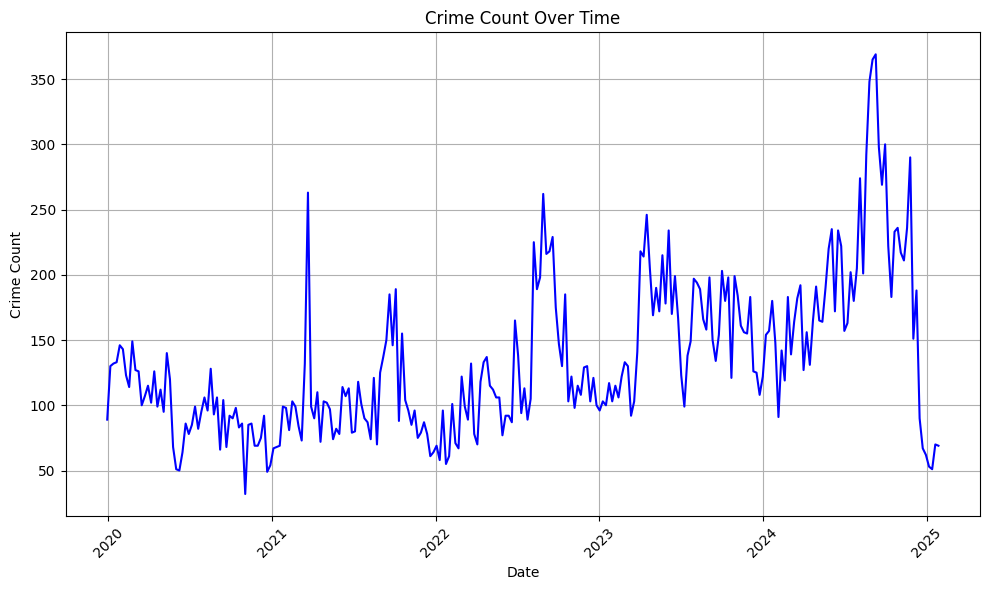

In [35]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot.index, ts_pivot[222], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

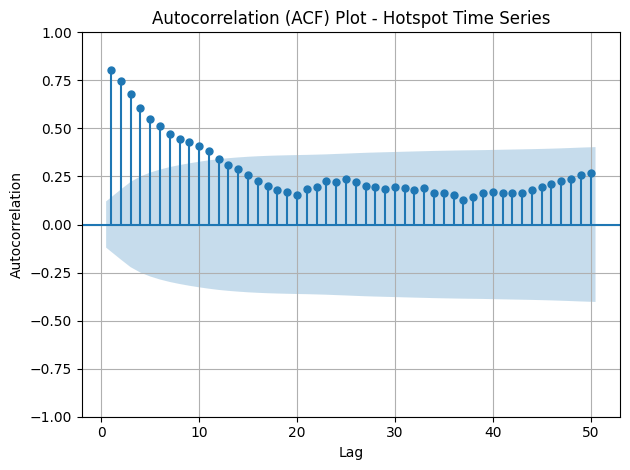

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[222].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[222].values
dates = ts_pivot.index

# === Train-Test Split (80/20) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.0757
p-value: 0.0011
=> Stationary


In [38]:
# Use the raw values directly for training and testing

hotspot_series = ts_pivot[222].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [ 89. 130. 132. 133. 146.]
y_test (original data): [180. 148.  91. 142. 119.]


In [39]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[222].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 39
AR RMSE: 82.12
AR MAPE: 40.24%


In [40]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[222].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (1, 0, 0), Seasonal: (2, 2, 2) x 7
SARIMA RMSE: 75.98
SARIMA MAPE: 44.95%


In [41]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[222].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 81.33
XGBoost MAPE: 32.20%



For lag = 1
Test RMSE: 45.5203
MAPE: 21.29%

For lag = 2
Test RMSE: 43.7675
MAPE: 21.12%

For lag = 3
Test RMSE: 43.8802
MAPE: 21.73%

For lag = 4
Test RMSE: 44.4455
MAPE: 22.33%

For lag = 6
Test RMSE: 45.4622
MAPE: 23.58%

For lag = 9
Test RMSE: 45.7524
MAPE: 24.61%

For lag = 12
Test RMSE: 45.7302
MAPE: 24.55%

For lag = 16
Test RMSE: 49.1500
MAPE: 27.63%

For lag = 24
Test RMSE: 48.4708
MAPE: 27.30%

For lag = 30
Test RMSE: 49.1732
MAPE: 27.82%

For lag = 40
Test RMSE: 49.6901
MAPE: 28.02%

For lag = 50
Test RMSE: 52.1844
MAPE: 28.86%


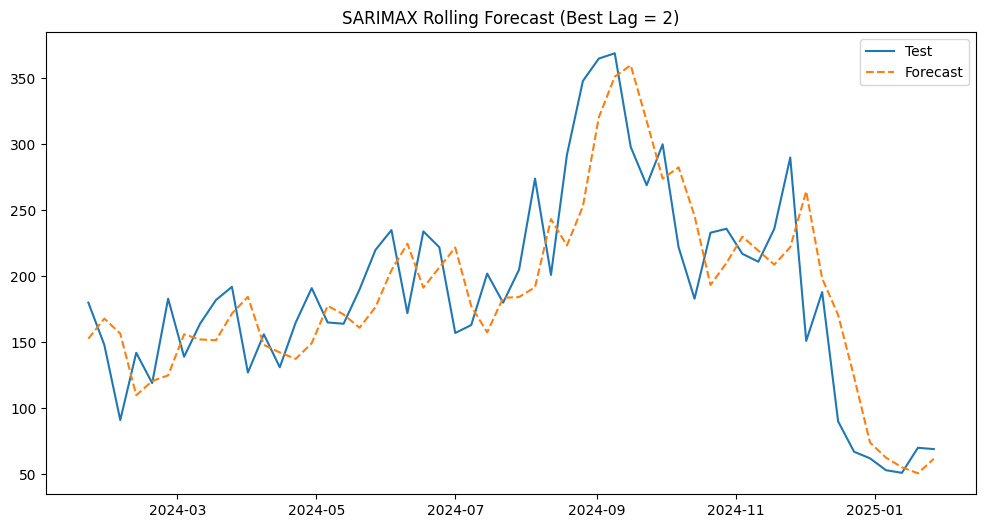

In [42]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[222].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.1091
Epoch 2, Loss: 0.1042
Epoch 3, Loss: 0.1033
Epoch 4, Loss: 0.0907
Epoch 5, Loss: 0.0944
Epoch 6, Loss: 0.0891
Epoch 7, Loss: 0.0912
Epoch 8, Loss: 0.0908
Epoch 9, Loss: 0.0877
Epoch 10, Loss: 0.0807
Epoch 11, Loss: 0.0758
Epoch 12, Loss: 0.0757
Epoch 13, Loss: 0.0723
Epoch 14, Loss: 0.0699
Epoch 15, Loss: 0.0700
Epoch 16, Loss: 0.0693
Epoch 17, Loss: 0.0701
Epoch 18, Loss: 0.0668
Epoch 19, Loss: 0.0688
Epoch 20, Loss: 0.0756
Epoch 21, Loss: 0.0716
Epoch 22, Loss: 0.0660
Epoch 23, Loss: 0.0691
Epoch 24, Loss: 0.0698
Epoch 25, Loss: 0.0686
Epoch 26, Loss: 0.0628
Epoch 27, Loss: 0.0721
Epoch 28, Loss: 0.0733
Epoch 29, Loss: 0.0684
Epoch 30, Loss: 0.0725
Epoch 31, Loss: 0.0720
Epoch 32, Loss: 0.0693
Epoch 33, Loss: 0.0707
Epoch 34, Loss: 0.0733
Epoch 35, Loss: 0.0665
Epoch 36, Loss: 0.0675
Epoch 37, Loss: 0.0672
Epoch 38, Loss: 0.0718
Epoch 39, Loss: 0.0642
Epoch 40, Loss: 0.0650
Epoch 41, Loss: 0.0642
Epoch 42, Loss: 0.0637
Epoch 43, Loss: 0.0718
Epoch 44, Loss: 0.06

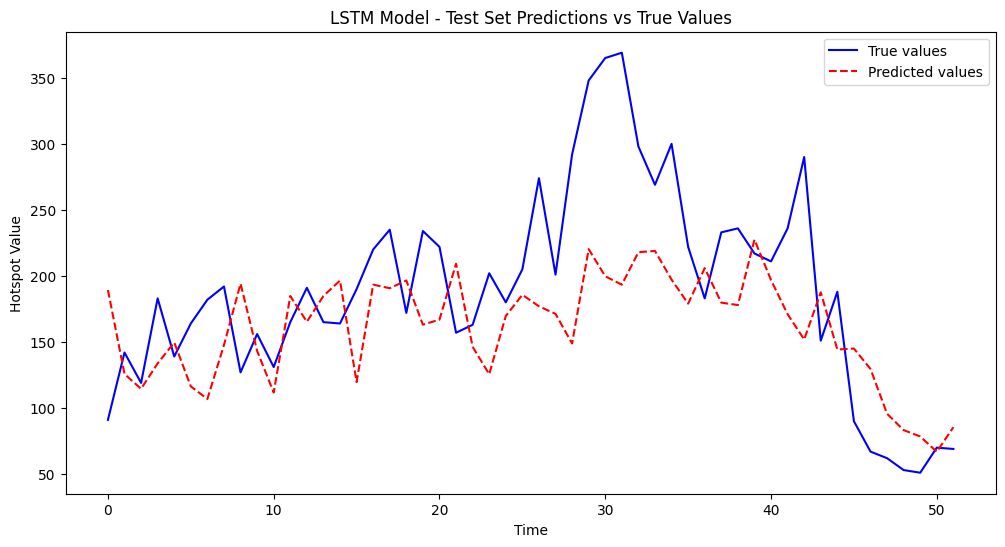

Test RMSE: 65.8840
Test MAPE: 28.62%


In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[222].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


### Second Largest Cluster

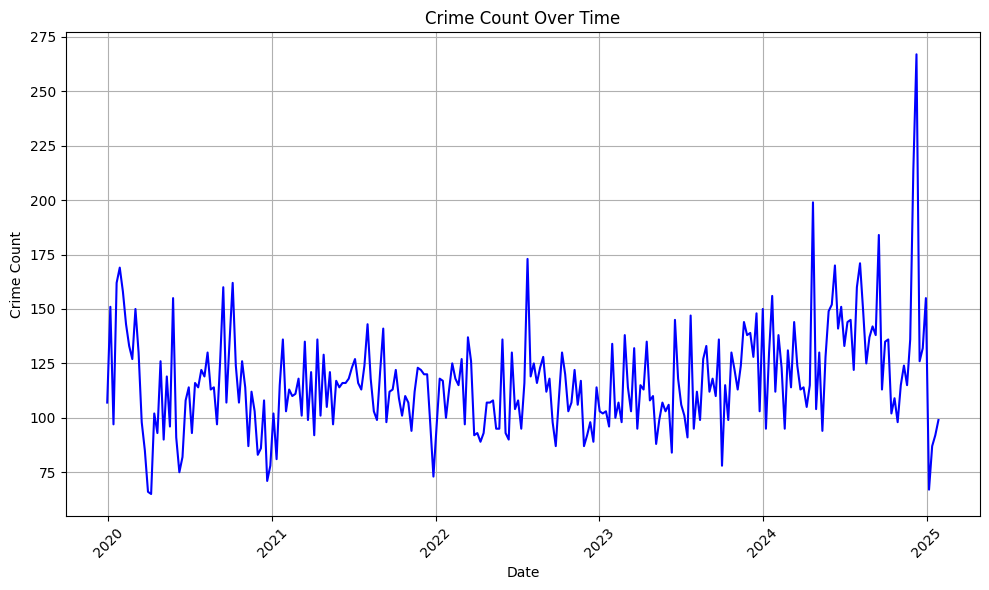

In [44]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot.index, ts_pivot[201], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

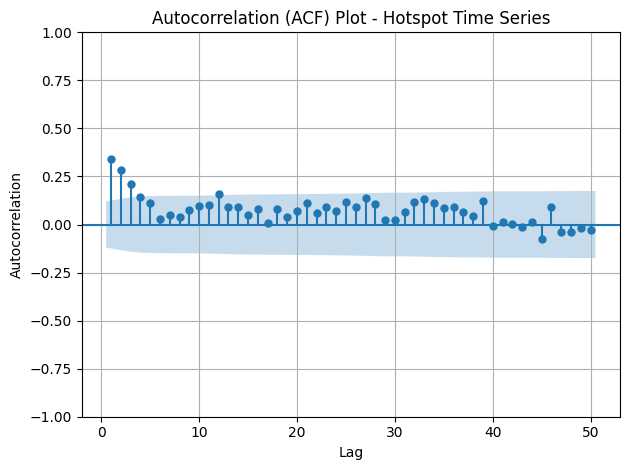

In [45]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[201].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[201].values
dates = ts_pivot.index

# === Train-Test Split (80/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -5.0743
p-value: 0.0000
=> Stationary


In [47]:

hotspot_series = ts_pivot[201].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Now, y_train and y_test contain the raw data without any scaling.
# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [107. 151.  97. 162. 169.]
y_test (original data): [156. 112. 138. 123.  95.]


In [48]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[201].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 1
AR RMSE: 38.35
AR MAPE: 18.49%


In [49]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[201].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (0, 1, 0), Seasonal: (2, 0, 1) x 7
SARIMA RMSE: 32.83
SARIMA MAPE: 17.69%


In [50]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[201].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 36.94
XGBoost MAPE: 17.83%



For lag = 1
Test RMSE: 38.0618
MAPE: 21.71%

For lag = 2
Test RMSE: 36.4328
MAPE: 19.72%

For lag = 3
Test RMSE: 35.1249
MAPE: 18.70%

For lag = 4
Test RMSE: 36.0238
MAPE: 19.24%

For lag = 6
Test RMSE: 36.2002
MAPE: 18.81%

For lag = 9
Test RMSE: 35.6848
MAPE: 18.96%

For lag = 12
Test RMSE: 34.9272
MAPE: 18.72%

For lag = 16
Test RMSE: 36.1966
MAPE: 19.89%

For lag = 24
Test RMSE: 36.6364
MAPE: 20.40%

For lag = 30
Test RMSE: 37.2833
MAPE: 20.44%

For lag = 40
Test RMSE: 36.7029
MAPE: 20.40%

For lag = 50
Test RMSE: 35.6534
MAPE: 20.18%


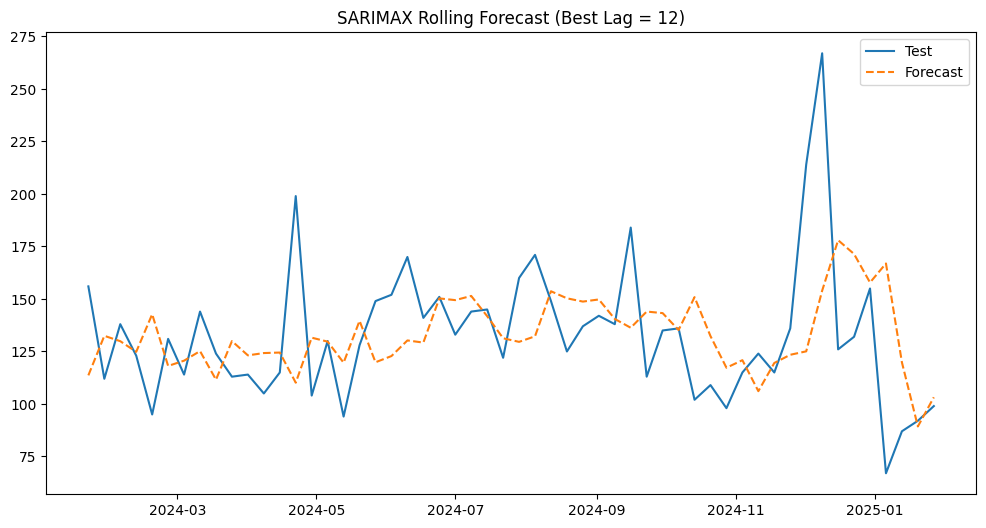

In [51]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[201].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.4470
Epoch 2, Loss: 0.4120
Epoch 3, Loss: 0.4160
Epoch 4, Loss: 0.4122
Epoch 5, Loss: 0.4035
Epoch 6, Loss: 0.4104
Epoch 7, Loss: 0.3993
Epoch 8, Loss: 0.4085
Epoch 9, Loss: 0.3887
Epoch 10, Loss: 0.3906
Epoch 11, Loss: 0.3852
Epoch 12, Loss: 0.4099
Epoch 13, Loss: 0.3938
Epoch 14, Loss: 0.3843
Epoch 15, Loss: 0.4023
Epoch 16, Loss: 0.4078
Epoch 17, Loss: 0.3919
Epoch 18, Loss: 0.3908
Epoch 19, Loss: 0.4056
Epoch 20, Loss: 0.3879
Epoch 21, Loss: 0.3797
Epoch 22, Loss: 0.3842
Epoch 23, Loss: 0.3936
Epoch 24, Loss: 0.3782
Epoch 25, Loss: 0.3876
Epoch 26, Loss: 0.3862
Epoch 27, Loss: 0.3771
Epoch 28, Loss: 0.3874
Epoch 29, Loss: 0.3856
Epoch 30, Loss: 0.3950
Epoch 31, Loss: 0.3968
Epoch 32, Loss: 0.3837
Epoch 33, Loss: 0.3807
Epoch 34, Loss: 0.3761
Epoch 35, Loss: 0.4051
Epoch 36, Loss: 0.3772
Epoch 37, Loss: 0.3836
Epoch 38, Loss: 0.3895
Epoch 39, Loss: 0.3768
Epoch 40, Loss: 0.3760
Epoch 41, Loss: 0.3819
Epoch 42, Loss: 0.3716
Epoch 43, Loss: 0.3838
Epoch 44, Loss: 0.37

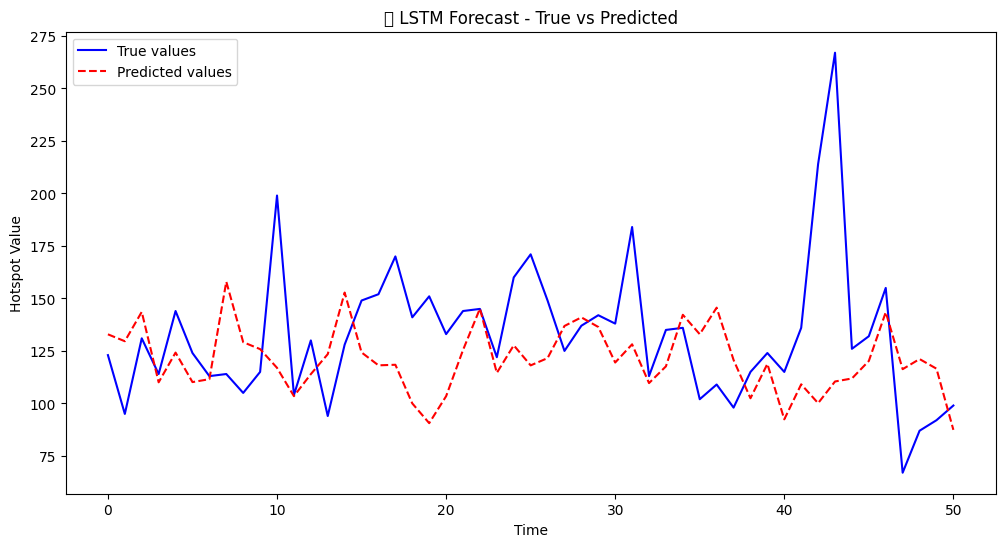

✅ Test RMSE: 39.4309
✅ Test MAPE: 20.03%


In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Use your actual ts_pivot DataFrame
series = ts_pivot[201].dropna().values.reshape(-1, 1)

# Normalize using robust scaler to reduce influence of outliers
scaler = RobustScaler()
series_scaled = scaler.fit_transform(series)

# Sequence creation function
def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Generate sequences
SEQ_LEN = 14
X, y = create_sequences(series_scaled, SEQ_LEN)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define LSTM model
class BetterLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3):
        super(BetterLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # get last time step
        return self.fc(out)

# Initialize model
model = BetterLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 200
best_loss = float('inf')
patience, wait = 10, 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True values', color='blue')
plt.plot(y_pred_inv, label='Predicted values', color='red', linestyle='--')
plt.title("📈 LSTM Forecast - True vs Predicted")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"✅ Test RMSE: {rmse:.4f}")
print(f"✅ Test MAPE: {mape * 100:.2f}%")
